In [1]:
#Raw data displayed
#plots created by Robin Uhrich
#modified by Lilli DIederichs

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.dwd_data import DWD_Dataset, Feature

import polars as pl
import pandas as pd
import datetime
import matplotlib
import seaborn as sn


#Tueplots
from scipy.stats import linregress
import matplotlib.colors as mcolors
from tueplots import cycler, markers,figsizes, fonts
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes

#Legend
import matplotlib.lines as mlines

In [2]:
#Plotting Params

plt.rcParams.update(figsizes.icml2022_full())
tue_plot_colors = palettes.tue_plot
from studies.utils.setup_pyplot import (
    SIDEEFFECTS_setup_tueplot,
    SIDEEFFECTS_choose_color_palette,
)
SIDEEFFECTS_setup_tueplot()
FIG_SAVE_BASE_PATH = '../docs/report/fig/'

In [3]:
#Import dataset
dataset_model_1 = DWD_Dataset(
    source_path="../data/dwd",
    model=1,
    feature=Feature.PRECIPITATION
)
dataset_model_2 = DWD_Dataset(
    source_path="../data/dwd",
    model=2,
    feature=Feature.PRECIPITATION
)

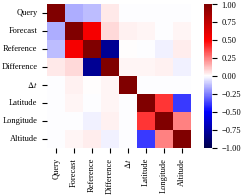

In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def get_delta_seconds(series):
    return series.total_seconds()


merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

station_meta = dataset_model_1._stations
used_station_ids = merge1["station_id"].unique()
station_meta = station_meta[
    station_meta["Stations_ID"].isin(used_station_ids)
    & (station_meta["Kennung"] == "MN")
]
coords = station_meta[["Stations_ID", "Breite", "Länge", "Stations-höhe"]]
coords = coords.rename(
    columns={
        "Stations_ID": "station_id",
        "Breite": "Latitude",
        "Länge": "Longitude",
        "Stations-höhe": "Altitude",
    }
)
merge1["day"] = merge1["time"].dt.day
time_delta = (merge1["time"] - merge1["call_time"]).apply(get_delta_seconds)
merge1["time_delta"] = time_delta
merge1 = pd.merge(merge1, coords, how="left", on="station_id")

# Drop the original datetime column
merge1 = merge1.drop(columns="time")
merge1 = merge1.drop(columns="station_id")
merge1 = merge1.drop(columns="day")

#Plot Correlation Matrix
fig, axs = plt.subplots()
axs.set_aspect('equal')
#axs.set_title('Correlation Matrix')
names = merge1.columns
corr = merge1.corr()

ylabel = ["Query", "Forecast", "Reference", "Difference", "$\Delta t$", "Latitude", "Longitude", "Altitude"]
heatmap = sn.heatmap(corr, cmap="seismic", yticklabels=ylabel, xticklabels=ylabel, vmin=-1, vmax=1, ax=axs)

# Rotate x-axis labels by 90 degrees
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

plt.savefig(os.path.join(FIG_SAVE_BASE_PATH,'fig_correlation_matrix.pdf'))
